
Target: predict if the item will be sold and how soon

This problem can be transformed to classification problem, where target is days till sell interval.

In [1]:
import os
import sys
import warnings
import math

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.pre_proc.utils import (convert_strings_to_categories,
                                get_time_related_columns,
                                replace_categorical_features_to_numerical_codes,
                                replace_numerical_missing_values_with_medians)

from src.models.utils import get_readable_model_scores, rmse

In [3]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

def preprocessing_pipeline_days_till_sell(df):
    # Remove sale_time related columns.
    sale_time_columns = get_time_related_columns(df.columns, 'sale_time')
    train_columns = list(set(df.columns) - set(sale_time_columns) - set(['days_till_sell']))
    df = df[train_columns]
    df = pd.get_dummies(df, columns=['gender',
                                     'state',
                                     'paid_organic',
                                     'catalog_code_1',
                                     'color_primary',
                                     'package_size_code'], dummy_na=True)
    df = replace_categorical_features_to_numerical_codes(df)
    df = replace_numerical_missing_values_with_medians(df)
    return df

In [4]:
df_raw = pd.read_parquet('../data/prepared_data.parquet', engine='pyarrow')
#Somehow I need to do object convertion to category again, after read_parquet.
df_raw = convert_strings_to_categories(df_raw)

In [5]:
np.sum(df_raw['days_till_sell'].isna())

615735

In [6]:
np.sum(df_raw['days_till_sell'].isna()) / df_raw.shape[0]

0.8344095434655637

We have 615735 unsold items and it is 83% of all sample. Here I see a problem how to correctlly distinguish sold and unsold items.
* Sold items can be extracted by filtering not null days_till_sell values.
* Unsold items can't be extracted by filtering null days_till_sell values, because it isn't clear currently, if this item is still unsold.

Due to I will pay attention on sold items and solve classification problem by dividing days_till_sell values into meaningful bins.

In [7]:
df = df_raw[df_raw['days_till_sell'].notnull()]

In [8]:
df['days_till_sell'].describe()

count    122194.000000
mean         36.717687
std          57.436777
min           0.000000
25%           2.000000
50%          12.000000
75%          45.000000
max         386.000000
Name: days_till_sell, dtype: float64

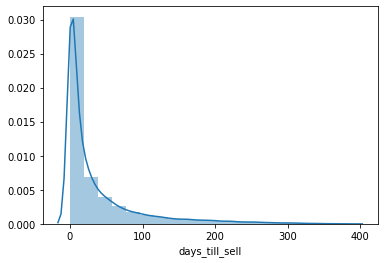

In [9]:
sns.distplot(df['days_till_sell'], bins = 20);

In [10]:
hist, bin_edges = np.histogram(df['days_till_sell'], bins = 20)
hist / hist.sum(), bin_edges

(array([5.86943712e-01, 1.33885461e-01, 7.65340360e-02, 5.14673388e-02,
        3.33076910e-02, 2.45920422e-02, 2.02955955e-02, 1.39859568e-02,
        1.24065011e-02, 1.04833298e-02, 9.01844608e-03, 7.07890731e-03,
        5.31122641e-03, 4.85293877e-03, 3.28985057e-03, 2.58605169e-03,
        1.93953877e-03, 1.11298427e-03, 6.13778091e-04, 2.94613483e-04]),
 array([  0. ,  19.3,  38.6,  57.9,  77.2,  96.5, 115.8, 135.1, 154.4,
        173.7, 193. , 212.3, 231.6, 250.9, 270.2, 289.5, 308.8, 328.1,
        347.4, 366.7, 386. ]))

In [11]:
np.sum((hist / hist.sum())[:14])

0.9901631831350147

### Create meaningful bins for days till sell and convert problem to classification task.

In [12]:
target = 'days_till_sell_bins'

In [13]:
df[target] = pd.cut(x=df['days_till_sell'], bins=[0, 3, 10, 30, 90, 720], include_lowest=True)

In [14]:
df[[target]].groupby([target]).size()

days_till_sell_bins
(-0.001, 3.0]    38191
(3.0, 10.0]      19594
(10.0, 30.0]     24780
(30.0, 90.0]     24044
(90.0, 720.0]    15585
dtype: int64

In [15]:
df.shape

(122194, 171)

In [16]:
df = preprocessing_pipeline_days_till_sell(df)

In [17]:
df.shape

(122194, 279)

In [18]:
df_subset = df.sample(frac=0.1, random_state=10)
train_columns = list(set(df_subset.columns) - set([target]))

In [19]:
df_subset.shape

(12219, 279)

### Model selection

In [117]:
classifiers = {'LR': LogisticRegression(),
               'LDA': LinearDiscriminantAnalysis(),
               'KNN': KNeighborsClassifier(),
               'NB': GaussianNB(),
               'CART': DecisionTreeClassifier(),
               'xgboost': XGBClassifier()}

results = []
for model_name, classifier in classifiers.items():
    kfold = KFold(n_splits=3, random_state=21)
    cv_results = cross_val_score(classifier,
                                 df_subset[train_columns],
                                 df_subset[target],
                                 cv=kfold,
                                 scoring='accuracy')
    
    results.append(cv_results)
    msg = "%s: %f (%f)" % (model_name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.318602 (0.010281)
LDA: 0.236190 (0.002431)
KNN: 0.274409 (0.006212)
NB: 0.219412 (0.009856)
CART: 0.271708 (0.002408)
xgboost: 0.332760 (0.008567)


After simple classifiers analysis I will go further with xgboost model, because nowadays it is one of the best models with high accuracy and performance, which robust to outliers, doesnt need normalization, handles missing values.

### Baseline

In [65]:
df_subset = df.sample(frac=0.3, random_state=10)

X_train, X_test, y_train, y_test = train_test_split(df_subset[train_columns],
                                                    df_subset[target],
                                                    test_size=0.2,
                                                    random_state=10)
model = XGBClassifier(n_jobs=-1)
model.fit(X_train, y_train)


print(confusion_matrix(y_train, model.predict(X_train)))
print(confusion_matrix(y_test, model.predict(X_test)))
print(accuracy_score(y_train, model.predict(X_train)))
print(accuracy_score(y_test, model.predict(X_test)))

[[8559   19  228  373  196]
 [3765  108  215  383  181]
 [4427   18  690  526  229]
 [4051    8  271 1091  308]
 [2523    8  112  376  661]]
[[2027    8   81  114   49]
 [ 947    5   68   94   54]
 [1166    7  125  143   66]
 [1096    6   86  195   69]
 [ 655    1   30  101  139]]
0.37881061174384506
0.33974358974358976


### Feature selection

In [122]:
model = XGBClassifier(n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("accuracy_score: %.2f" % (accuracy))
# Fit model using each importance as a threshold
feature_importance = model.feature_importances_
thresholds = np.sort(feature_importance[feature_importance > 0.01])
results = []
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier(n_jobs=-1)
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    results.append([thresh, accuracy])
    print("Thresh=%.3f, n=%d, accuracy_score: %.2f" % (thresh, select_X_train.shape[1], accuracy))

accuracy_score: 0.34
Thresh=0.011, n=12, accuracy_score: 0.33
Thresh=0.012, n=11, accuracy_score: 0.34
Thresh=0.012, n=10, accuracy_score: 0.34
Thresh=0.012, n=9, accuracy_score: 0.34
Thresh=0.012, n=8, accuracy_score: 0.34
Thresh=0.013, n=7, accuracy_score: 0.34
Thresh=0.013, n=6, accuracy_score: 0.33
Thresh=0.013, n=5, accuracy_score: 0.32
Thresh=0.013, n=4, accuracy_score: 0.32
Thresh=0.014, n=3, accuracy_score: 0.32
Thresh=0.016, n=2, accuracy_score: 0.32
Thresh=0.031, n=1, accuracy_score: 0.32


In [66]:
feature_importance = rf_feat_importance(model, X_train)

In [68]:
feature_importance

cols       imp
65                           local_timeDayofyear  0.032095
72                                catalog_code_2  0.022654
120                        listing_activity_mean  0.020594
213                    lister_nth_day_of_listing  0.015156
161                              window_gmv_sold  0.014977
92                         listing_platform_mean  0.014127
195                                     birthday  0.013741
255                                    brand_max  0.012786
166                   registration_platform_mean  0.012381
53                        catalog_code_1_BUNDLES  0.011560
269                               catalog_code_3  0.010958
268                          catalog_code_2_mean  0.010505
193                               local_timeWeek  0.010331
250                            window_items_sold  0.010120
15                 days_since_user_first_listing  0.010029
14                           listing_price_local  0.009757
225                          catalog_code_1_mean  0.009393
194                  registration_local_timeWeek  0.009360
149                                     state_NC  0.009252
156                           lister_nth_listing  0.009129
203                           total_items_listed  0.009066
40                            catalog_code_3_max  0.009065
264                                     city_min  0.009008
164                          window_items_listed  0.008978
85                                         brand  0.008959
240                     package_size_code_MEDIUM  0.008922
25                                 birthday_mean  0.008730
49             first_listing_local_timeDayofyear  0.008702
167                total_positive_feedback_count  0.008564
150                                     state_SD  0.008498
36                              total_items_sold  0.008413
174                               total_gmv_sold  0.008374
11                          listing_platform_max  0.008357
46                                      state_MA  0.008297
68                                catalog_code_4  0.008259
180                                   brand_mean  0.008196
39                                      size_max  0.007991
56                       package_size_code_SMALL  0.007920
103                    first_sale_local_timeHour  0.007885
94                              acquisition_type  0.007875
248                                     state_NV  0.007804
127                                     state_OH  0.007800
235                                    state_max  0.007662
233                          catalog_code_1_MENS  0.007500
224                                     state_RI  0.007499
190                                 birthday_max  0.007425
18                first_sale_local_timeDayofyear  0.007324
97                     second_sale_local_timeDay  0.007181
254                   registration_full_utm_mean  0.007140
121                                        title  0.007121
198              second_sale_local_timeDayofweek  0.007118
135             basic_verification_local_timeDay  0.007037
165                             total_gmv_bought  0.006988
176       first_upload_form_visit_local_timeWeek  0.006953
242                                local_timeDay  0.006882
236        first_upload_form_visit_local_timeDay  0.006840
51                           catalog_code_4_mean  0.006724
84               second_sale_local_timeDayofyear  0.006715
207                          registration_app_id  0.006677
222                         total_feedback_count  0.006665
87                                    state_mean  0.006606
189                total_negative_feedback_count  0.006531
23                    second_sale_local_timeWeek  0.006512
4                        days_since_registration  0.006476
187                                    title_min  0.006462
41                                      state_IN  0.006452
261                 total_neutral_feedback_count  0.006382
1                       first_sa

In [69]:
important_features = feature_importance[feature_importance.imp > 0.009].cols.tolist()

In [70]:
important_features

['local_timeDayofyear',
 'catalog_code_2',
 'listing_activity_mean',
 'lister_nth_day_of_listing',
 'window_gmv_sold',
 'listing_platform_mean',
 'birthday',
 'brand_max',
 'registration_platform_mean',
 'catalog_code_1_BUNDLES',
 'catalog_code_3',
 'catalog_code_2_mean',
 'local_timeWeek',
 'window_items_sold',
 'days_since_user_first_listing',
 'listing_price_local',
 'catalog_code_1_mean',
 'registration_local_timeWeek',
 'state_NC',
 'lister_nth_listing',
 'total_items_listed',
 'catalog_code_3_max',
 'city_min']

### Xgboost tunning

In [71]:
X_train, X_test, y_train, y_test = train_test_split(df_subset[important_features],
                                                    df_subset[target],
                                                    test_size=0.2,
                                                    random_state=10)
model = XGBClassifier(n_jobs=-1, n_estimators=200)
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["merror"]
model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

[0]	validation_0-merror:0.67227	validation_1-merror:0.684124
[1]	validation_0-merror:0.671998	validation_1-merror:0.687125
[2]	validation_0-merror:0.671725	validation_1-merror:0.682897
[3]	validation_0-merror:0.671281	validation_1-merror:0.683852
[4]	validation_0-merror:0.670361	validation_1-merror:0.683306
[5]	validation_0-merror:0.670361	validation_1-merror:0.685079
[6]	validation_0-merror:0.670224	validation_1-merror:0.68467
[7]	validation_0-merror:0.670463	validation_1-merror:0.684943
[8]	validation_0-merror:0.670224	validation_1-merror:0.684261
[9]	validation_0-merror:0.670054	validation_1-merror:0.685761
[10]	validation_0-merror:0.671247	validation_1-merror:0.684943
[11]	validation_0-merror:0.670327	validation_1-merror:0.685215
[12]	validation_0-merror:0.669406	validation_1-merror:0.683988
[13]	validation_0-merror:0.669542	validation_1-merror:0.683715
[14]	validation_0-merror:0.669133	validation_1-merror:0.683715
[15]	validation_0-merror:0.66927	validation_1-merror:0.68317
[16]	v

[131]	validation_0-merror:0.627839	validation_1-merror:0.669258
[132]	validation_0-merror:0.627259	validation_1-merror:0.669122
[133]	validation_0-merror:0.626782	validation_1-merror:0.66844
[134]	validation_0-merror:0.626816	validation_1-merror:0.668576
[135]	validation_0-merror:0.626509	validation_1-merror:0.668031
[136]	validation_0-merror:0.6261	validation_1-merror:0.668167
[137]	validation_0-merror:0.625997	validation_1-merror:0.667894
[138]	validation_0-merror:0.625418	validation_1-merror:0.667758
[139]	validation_0-merror:0.625554	validation_1-merror:0.667758
[140]	validation_0-merror:0.625315	validation_1-merror:0.667485
[141]	validation_0-merror:0.625418	validation_1-merror:0.667076
[142]	validation_0-merror:0.625111	validation_1-merror:0.666939
[143]	validation_0-merror:0.62477	validation_1-merror:0.666394
[144]	validation_0-merror:0.624497	validation_1-merror:0.666394
[145]	validation_0-merror:0.62419	validation_1-merror:0.667212
[146]	validation_0-merror:0.624224	validation

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

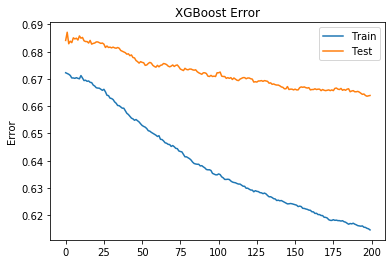

In [72]:
results = model.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('Error')
plt.title('XGBoost Error')
plt.show()

it looks like our model starts to overfit a lot from  30 iterations.

### Model tunning

In [75]:
 param_test1 = {
    'max_depth': range(3, 15, 3),
    'min_child_weight': range(3, 15, 3),
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(n_estimators=30, n_jobs=-1), 
                        param_grid = param_test1, scoring='neg_log_loss', n_jobs=-1, iid=False, cv=5)
gsearch1.fit(df_subset[important_features], df_subset[target])
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 12, 'min_child_weight': 9}, -1.4800945104811742)

In [76]:
param_test3 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier(n_estimators=60, max_depth=12, min_child_weight=9), 
                        param_grid = param_test3, scoring='neg_log_loss', n_jobs=4, iid=False, cv=5)
gsearch3.fit(df_subset[important_features], df_subset[target])
gsearch3.best_params_, gsearch3.best_score_

({'colsample_bytree': 0.6, 'subsample': 0.9}, -1.4665889522867772)

In [78]:
param_test2 = {
 'gamma':[i/10.0 for i in range(0, 50, 10)]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier(n_estimators=60, max_depth=12, min_child_weight=9, colsample_bytree=0.6, subsample=0.9),
                                                  param_grid = param_test2, scoring='neg_log_loss', n_jobs=4, iid=False, cv=5)
gsearch2.fit(df_subset[important_features], df_subset[target])
gsearch2.best_params_, gsearch2.best_score_

({'gamma': 1.0}, -1.4658255350611038)

### Apply tuned model on subset

In [83]:
model = XGBClassifier(n_estimators=60,
                      max_depth=12, 
                      min_child_weight=9,
                      colsample_bytree=0.6,
                      subsample=0.9,
                      gamma=1,
                      n_jobs=-1)

kfold = KFold(n_splits=5, random_state=7)
results = cross_val_score(model,
                          df_subset[important_features],
                          df_subset[target],
                          cv=kfold,
                          scoring='neg_log_loss')
print("neg_log_loss: %.2f (%.2f)" % (results.mean(), results.std()))

neg_log_loss: -1.47 (0.01)


In [88]:
model = XGBClassifier(n_estimators=60,
                      max_depth=12, 
                      min_child_weight=9,
                      colsample_bytree=0.6,
                      subsample=0.9,
                      gamma=1,
                      n_jobs=-1)

model.fit(X_train, y_train)
print(confusion_matrix(y_train, model.predict(X_train)))
print(confusion_matrix(y_test, model.predict(X_test)))
print(accuracy_score(y_train, model.predict(X_train)))
print(accuracy_score(y_test, model.predict(X_test)))

[[8999   27  107  143   99]
 [1962 1856  275  345  214]
 [1807   53 3551  283  196]
 [1437   45  177 3880  190]
 [ 980   36  107  192 2365]]
[[1650   71  200  239  119]
 [ 712   80  144  166   66]
 [ 820   62  242  261  122]
 [ 744   56  171  344  137]
 [ 434   20   87  164  221]]
0.7041874104889859
0.34601745771958536


### Apply tuned model on full dataset

In [90]:
model = XGBClassifier(n_estimators=60,
                      max_depth=12, 
                      min_child_weight=9,
                      colsample_bytree=0.6,
                      subsample=0.9,
                      gamma=1,
                      n_jobs=-1)

kfold = KFold(n_splits=5, random_state=7)
results = cross_val_score(model,
                          df[important_features],
                          df[target],
                          cv=kfold,
                          scoring='neg_log_loss')
print("neg_log_loss: %.2f (%.2f)" % (results.mean(), results.std()))

neg_log_loss: -1.42 (0.00)


In [92]:
X_train, X_test, y_train, y_test = train_test_split(df[important_features],
                                                    df[target],
                                                    test_size=0.1,
                                                    random_state=10)
model = XGBClassifier(n_estimators=60,
                      max_depth=12, 
                      min_child_weight=9,
                      colsample_bytree=0.6,
                      subsample=0.9,
                      gamma=1,
                      n_jobs=-1)

model.fit(X_train, y_train)
print(confusion_matrix(y_train, model.predict(X_train)))
print(confusion_matrix(y_test, model.predict(X_test)))
print(accuracy_score(y_train, model.predict(X_train)))
print(accuracy_score(y_test, model.predict(X_test)))

[[31335   236   740  1131   799]
 [ 8820  4720  1308  1743  1051]
 [ 8638   319 10637  1623  1172]
 [ 6995   212   943 12229  1266]
 [ 4239   112   495  1189  8022]]
[[3018   84  289  370  189]
 [1140  143  241  274  154]
 [1224   76  507  392  192]
 [1130   45  269  675  280]
 [ 656   26  110  254  482]]
0.6087166057431757
0.39484451718494273


### Error analysis

* (-0.001, 3.0] - TP = 3018 / 3950 = 76%. Model accurately predicts if item will be sold during (-0.001, 3.0] days.
* (3.0, 10.0] - TP = 143 / 1952 = 7%. Model incorrectly predicts if item will be sold during (3.0, 10.0] days. Majority of predictions are from (-0.001, 3.0] although true values are from (3.0, 10.0]. 
* (10.0, 30.0] - TP = 507 / 2391 = 21%. Model incorrectly predicts if item will be sold during (10.0, 30.0] days. Majority of predictions are from (-0.001, 3.0] although true values are from (10.0, 30.0].
* (30.0, 90.0] - TP = 675 / 2399 = 28%. Model incorrectly predicts if item will be sold during (30.0, 90.0] days. Majority of predictions are from (-0.001, 3.0] although true values are from (30.0, 90.0].
* (90.0, 720.0] - TP = 482 / 1528 = 32%. Model incorrectly predicts if item will be sold during (90.0, 720.0] days. Majority of predictions are from (-0.001, 3.0] although true values are from (90.0, 720.0].

According to error analysis we see, that model accurately predicts if the items will be sold during the first days. However performance become worse then trying to predict if the item will be sold in the later days.

### Final model

In [94]:
XGBClassifier(n_estimators=60,
                      max_depth=12, 
                      min_child_weight=9,
                      colsample_bytree=0.6,
                      subsample=0.9,
                      gamma=1,
                      n_jobs=-1)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=1,
              learning_rate=0.1, max_delta_step=0, max_depth=12,
              min_child_weight=9, missing=None, n_estimators=60, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)

In [95]:
important_features

['local_timeDayofyear',
 'catalog_code_2',
 'listing_activity_mean',
 'lister_nth_day_of_listing',
 'window_gmv_sold',
 'listing_platform_mean',
 'birthday',
 'brand_max',
 'registration_platform_mean',
 'catalog_code_1_BUNDLES',
 'catalog_code_3',
 'catalog_code_2_mean',
 'local_timeWeek',
 'window_items_sold',
 'days_since_user_first_listing',
 'listing_price_local',
 'catalog_code_1_mean',
 'registration_local_timeWeek',
 'state_NC',
 'lister_nth_listing',
 'total_items_listed',
 'catalog_code_3_max',
 'city_min']

### Final remarks
#### Next steps would be:
* Try different categorization approach.
* Try to solve regression problem.
* Apply ensamble methods.
* Apply automatic features creation tools.
* Fix data quality issues.
* Apply nlp for features creation.